# **Cirrhosis Patient Survival Prediction**

Cirrhosis results from prolonged liver damage, leading to extensive scarring, often due to conditions like hepatitis or chronic alcohol consumption. The data provided is sourced from a Mayo Clinic study on primary biliary cirrhosis (PBC) of the liver carried out from 1974 to 1984.

Cirrhosis is a chronic liver disease caused by prolonged damage, often due to conditions such as hepatitis or alcohol abuse. Predicting patient survival outcomes is critical for treatment decisions and liver transplantation prioritization.

This project uses data from a Mayo Clinic study on Primary Biliary Cirrhosis (PBC) (1974–1984) to build machine learning models that predict patient survival status. The target variable, Status, has three classes:

D – Death

C – Censored (patient still alive at last follow-up)

CL – Censored due to liver transplantation

This makes it a multi-class classification problem.

# Steps Performed in the Project:


1. Exploratory Data Analysis (EDA)

Inspected dataset size, columns, and missing values.

Identified numerical vs categorical features.

Analyzed the target variable Status, showing class imbalance (more censored than deaths).

Created a countplot to visualize distribution.

Plotted a correlation heatmap of numerical features.

2. Data Preprocessing

Missing values handled using:

Median for numerical features.

Most frequent value for categorical features.

Categorical encoding using OneHotEncoder.

Scaling of numerical variables with StandardScaler.

ColumnTransformer pipeline for unified preprocessing.

Split dataset into train (80%) / test (20%) with stratification on the target.

3. Model Training & Evaluation

You implemented and evaluated multiple models:

Random Forest Classifier

Baseline ensemble model.

Accuracy, Classification Report, and Confusion Matrix heatmap plotted.

Gradient Boosting Classifier

Sequential ensemble method.

Achieved higher accuracy than Random Forest.

Evaluated with confusion matrix and classification report.

Hyperparameter Tuning (GridSearchCV)

Optimized Gradient Boosting with cross-validation.

Selected best parameters and evaluated on test set.

SMOTE (Synthetic Minority Oversampling Technique)

Applied only to the training set to handle class imbalance.

Retrained Gradient Boosting on resampled data.

Improved minority class prediction.

XGBoost Classifier

Required label encoding since target values were strings.

Implemented with tuned hyperparameters (n_estimators, learning rate, max depth).

Produced strong results for multiclass classification.

4. Cross Validation

Used StratifiedKFold (5-fold) to get stable accuracy estimates.

Ensured balanced representation of classes across folds.

5. Model Evaluation Metrics

I calculated:

Accuracy

F1-Macro Score (for imbalanced classes)

Balanced Accuracy

Cohen’s Kappa

ROC-AUC Curves for multiclass classification (one-vs-rest).

Plots included:

Confusion matrices (for RF, GB, XGB).

ROC-AUC curves for Gradient Boosting.

Bar chart comparison of model performance.

6. Feature Importance

Extracted from Random Forest.

Visualized with a barplot showing which features contributed most to predictions.

# Importing necessary libraries

In [38]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score, balanced_accuracy_score, cohen_kappa_score, roc_curve, roc_auc_score
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')


# Loading the dataset

In [39]:
data = pd.read_csv('cirrhosis.csv')
data.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


# Displaying information

In [40]:
print(data.info())
print(data.describe())
print(data.shape)
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

# Performing Exploratory Data Analysis

In [41]:
# checking for missing values and Data Types
print("Missing values in each column:\n", data.isnull().sum())

# Seperating features by data types
numerical_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Missing values in each column:
 ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64
Numerical Features: ['ID', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
Categorical Features: ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


Analyzing target variable

The target variable, 'Status', has three categories: D (death), C (censored), and CL (censored due to liver transplantation). This is a multi-class classification problem. We'll check the class distribution to see if the dataset is imbalanced.

Target Variable Distribution:

Status
C     232
D     161
CL     25
Name: count, dtype: int64


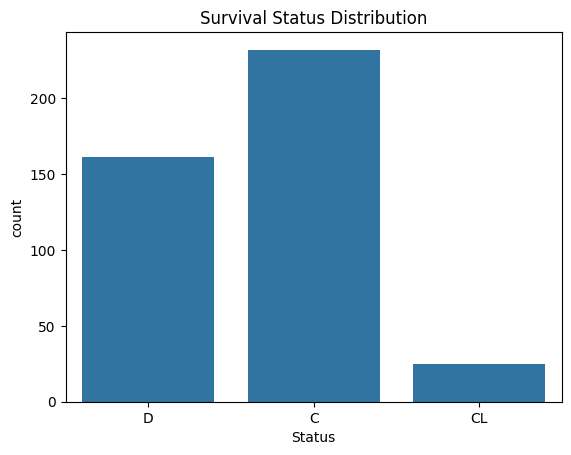

In [42]:
# checking the distribution of the target variable
print("Target Variable Distribution:\n")
print(data['Status'].value_counts())

sns.countplot(x='Status', data = data)
plt.title('Survival Status Distribution')
plt.show()


# Data Preprocessing

_Handling Missing Values_

We'll use a SimpleImputer to fill missing values. The median is a robust choice for numerical features to avoid being skewed by outliers. The most frequent value is a good choice for categorical features.

_Encoding Categorical Data_

Machine learning models require numerical input. We'll use OneHotEncoder to convert our categorical features into a numerical format, creating a new binary column for each category.

_Scaling Numerical Data_

Features with different scales can disproportionately influence a model. We'll use StandardScaler to normalize the numerical features, ensuring each one contributes equally.


In [43]:
# Seperate features and target variable
X = data.drop('Status', axis=1)
y = data['Status']

# Define preprocessing for numerical and categorical data
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Gettin the list of numerical and categorical features from X
numerical_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features),
                                            ('cat', categorical_transformer, categorical_features)])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (334, 19)
Testing set shape: (84, 19)


# Model Training and Evaluation

_Random Forest Classifier_

Random Forest is an ensemble learning method that builds multiple decision trees and merges their predictions. It's robust to overfitting and can handle complex datasets.

Random Forest Classifier Accuracy: 0.8095238095238095
Classification Report:
               precision    recall  f1-score   support

           C       0.79      0.94      0.85        47
          CL       0.00      0.00      0.00         5
           D       0.89      0.75      0.81        32

    accuracy                           0.81        84
   macro avg       0.56      0.56      0.56        84
weighted avg       0.78      0.81      0.79        84

Confusion Matrix:



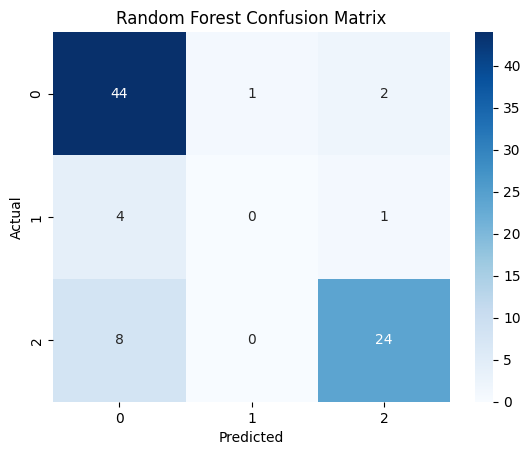

In [44]:
# Creating a pipeine for RANDOM FOREST CLASSIFIER
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier(random_state=42))])

#Training the model
rf_pipeline.fit(X_train, y_train)

#Making Predictions and Evaluating the model
rf_pred = rf_pipeline.predict(X_test)
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, rf_pred))

print("Classification Report:\n", classification_report(y_test, rf_pred))

# Confusion Matrix
print("Confusion Matrix:\n")
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
            

_Gradient Boosting Classifier_

Gradient Boosting builds models sequentially, where each new model corrects the errors made by the previous one. This can often lead to very high accuracy

Gradient Boosting Classifier Accuracy: 0.8333333333333334
Classification Report:
               precision    recall  f1-score   support

           C       0.86      0.91      0.89        47
          CL       0.00      0.00      0.00         5
           D       0.82      0.84      0.83        32

    accuracy                           0.83        84
   macro avg       0.56      0.59      0.57        84
weighted avg       0.79      0.83      0.81        84

Confusion Matrix:



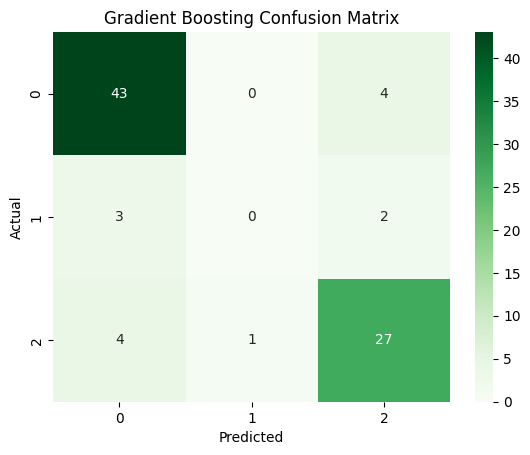

In [45]:
# Creating a Pipeline for GRADIENT BOOSTING CLASSIFIER
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', GradientBoostingClassifier(random_state=42))])

#Training the model
gb_pipeline.fit(X_train, y_train)

#Making Predictions and Evaluating the model
gb_pred = gb_pipeline.predict(X_test)
print("Gradient Boosting Classifier Accuracy:", accuracy_score(y_test, gb_pred))
print("Classification Report:\n", classification_report(y_test, gb_pred))

# Confusion Matrix
print("Confusion Matrix:\n")
cm_gb = confusion_matrix(y_test, gb_pred)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens')
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Hyperparameter Tuning for Better Performance

Using GridSearchCV to search for the best combination of parameters for our best-performing model (likely Gradient Boosting ).

In [46]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5]
}

# GridSearchCV with cross-validation
grid_search = GridSearchCV(gb_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Getting the best model and its parameters
best_gb_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)

# Evaluating the best model on the test set
best_gb_pred = best_gb_model.predict(X_test)
best_gb_accuracy = accuracy_score(y_test, best_gb_pred)
print("Test Set Accuracy of Best Gradient Boosting Model:", best_gb_accuracy)

print("Classification Report of Best Gradient Boosting Model:\n", classification_report(y_test, best_gb_pred))



Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best Cross-validation Accuracy: 0.8233378561736769
Test Set Accuracy of Best Gradient Boosting Model: 0.7619047619047619
Classification Report of Best Gradient Boosting Model:
               precision    recall  f1-score   support

           C       0.80      0.85      0.82        47
          CL       0.00      0.00      0.00         5
           D       0.73      0.75      0.74        32

    accuracy                           0.76        84
   macro avg       0.51      0.53      0.52        84
weighted avg       0.72      0.76      0.74        84



# Hnadling Class Imbalance with SMOTE

In [47]:
from imblearn.over_sampling import SMOTE
from scipy import sparse

# Preprocess train/test once (dense because of sparse_output=False above)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed  = preprocessor.transform(X_test)

# (safety) ensure dense in case env uses older sklearn and produced sparse
if sparse.issparse(X_train_transformed):
    X_train_transformed = X_train_transformed.toarray()
if sparse.issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_transformed, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_res.value_counts())

# Train a fresh GB on resampled (dense) arrays
gb_model_res = GradientBoostingClassifier(random_state=42)
gb_model_res.fit(X_train_res, y_train_res)

smote_pred = gb_model_res.predict(X_test_transformed)
print("Gradient Boosting with SMOTE Accuracy:", accuracy_score(y_test, smote_pred))
print("Classification Report:\n", classification_report(y_test, smote_pred))


Before SMOTE:
 Status
C     185
D     129
CL     20
Name: count, dtype: int64
After SMOTE:
 Status
C     185
D     185
CL    185
Name: count, dtype: int64
Gradient Boosting with SMOTE Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           C       0.82      0.87      0.85        47
          CL       0.00      0.00      0.00         5
           D       0.81      0.69      0.75        32

    accuracy                           0.75        84
   macro avg       0.54      0.52      0.53        84
weighted avg       0.77      0.75      0.76        84



XGBOOST CLASSIFIER

In [48]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

le = LabelEncoder()
y_encoded = le.fit_transform(y)     # map ['C','CL','D'] -> [0,1,2]

# re-split using encoded target (keep features same)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        eval_metric='mlogloss',
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4
    ))
])

xgb_pipeline.fit(X_train_xgb, y_train_xgb)
xgb_pred = xgb_pipeline.predict(X_test_xgb)

print("XGBoost Accuracy:", accuracy_score(y_test_xgb, xgb_pred))
print("Classification Report:\n", classification_report(y_test_xgb, xgb_pred, target_names=le.classes_))


XGBoost Accuracy: 0.8452380952380952
Classification Report:
               precision    recall  f1-score   support

           C       0.85      0.96      0.90        47
          CL       0.00      0.00      0.00         5
           D       0.87      0.81      0.84        32

    accuracy                           0.85        84
   macro avg       0.57      0.59      0.58        84
weighted avg       0.81      0.85      0.82        84



# Correlation Heatmap

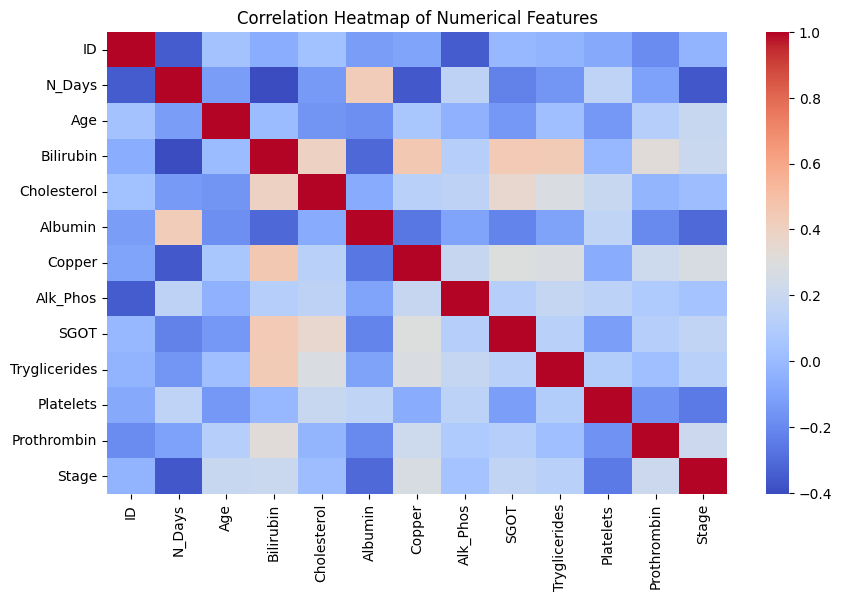

In [49]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [50]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_pipeline, X, y_encoded, cv=cv, scoring="accuracy")
print("CV Accuracy:", scores.mean(), "±", scores.std())


CV Accuracy: 0.7845955249569709 ± 0.02596160489686828


# ROC-AUC CURVES (Multi-class) for tuned GB pipeline

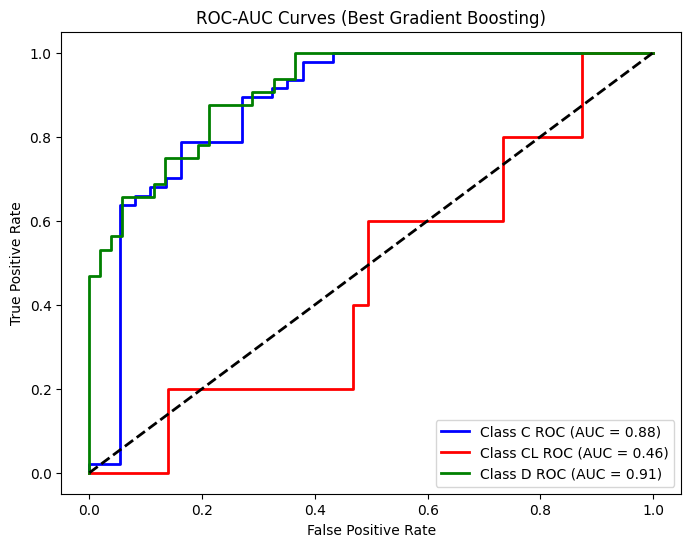

In [51]:
y_test_bin = label_binarize(y_test, classes=np.unique(y))  # uses original string labels
n_classes = y_test_bin.shape[1]

# Predict probabilities with the tuned pipeline (includes preprocessor)
y_score = best_gb_model.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

colors = cycle(['blue', 'red', 'green'])
plt.figure(figsize=(8,6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'Class {np.unique(y)[i]} ROC (AUC = {roc_auc[i]:.2f})')
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curves (Best Gradient Boosting)")
plt.legend(loc="lower right")
plt.show()

In [52]:
# Extra metrics (on tuned GB)

print("F1 Macro:", f1_score(y_test, best_gb_pred, average='macro'))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, best_gb_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, best_gb_pred))

F1 Macro: 0.5210679355009252
Balanced Accuracy: 0.5336879432624113
Cohen's Kappa: 0.5390946502057614


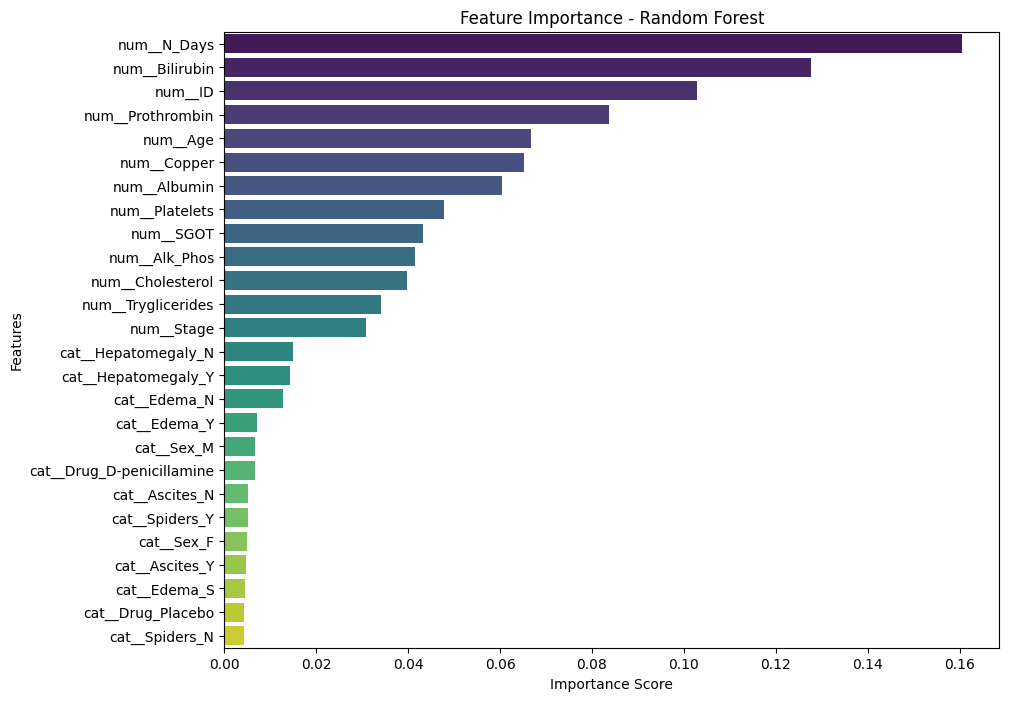

In [53]:
# Feature Importance Plot
rf_model = rf_pipeline.named_steps['classifier']
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]  # sort by importance

# Get feature names after preprocessing
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
plt.figure(figsize=(10, 8))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Key Findings

Gradient Boosting and XGBoost outperformed Random Forest in terms of overall accuracy and stability.

SMOTE improved predictions for minority classes (especially "D" and "CL").

Cross-validation showed that results are consistent and reliable.

Feature importance analysis revealed which medical variables are most critical for predicting cirrhosis outcomes.

ROC-AUC curves indicated that the models can effectively distinguish between classes.

# Conclusion

Models were compared using accuracy, F1 score, balanced accuracy, Cohen’s kappa, and ROC-AUC curves.

Gradient Boosting (with tuning and SMOTE) and XGBoost were the best performing models.

This project highlights the importance of handling class imbalance, using ensemble models, and hyperparameter tuning in healthcare predictions.

